# **Image Compression with SVD**

Singular Value Decomposition (SVD) is a powerful mathematical technique used to break down a matrix into simpler components. In the context of images, SVD can help us compress data by keeping only the most important features. This means we can reduce the size of an image file while maintaining its quality. In this notebook, we'll explore how SVD works and use it to efficiently compress images.


**Environment Setup**

We will be using ``` numpy.linalg.eigh ``` as a tool for calculating the eigenvalues and eigenvectors of a given hermitian matrix. Since we deal mostly with hermitian matrices, this function is used instead of ``` numpy.linalg.eig ``` to avoid numerical instabilities.


<b><font color='red' size=4><u>Notice: You are not allowed to use other capabilities of numpy.linalg or similar packages for SVD implementation.</u></b></font>

In [2]:
import numpy as np
from numpy.linalg import eigh
from PIL import Image
import matplotlib.pyplot as plt

tol = 1e-4

# **SVD Implementation**

<b><font size=4>$Σ$ & $V$ Construction</font></b>

As we have studied, Singular Value Decomposition factorizes a matrix into 3 matrices.

$$
  A = UΣV^T
$$

Where $Σ$ and $V$ are created by the eigenvalues and eigenvectors of $A^TA$ respectively. complete the function so that it receives a hermitian matrix ($A^TA$) and returns the square root of its eigenvalues in decreasing order and the respective eigenvectors.

In [35]:

def get_eval_evec(mat, tol):
    """
    Given a Hermitian matrix, this function returns:
    - A list of singular values
    - A matrix of corresponding eigenvectors

    Parameters:
    mat: A Hermitian matrix (real or complex)
    tol: A tolerance value to filter small eigenvalues

    Returns:
    - singular: List of singular values (sqrt of eigenvalues > tol)
    - vec: Eigenvectors corresponding to the sorted eigenvalues
    """
    # Ensure matrix is properly formatted
    matrix = np.array(mat, dtype=np.float64)

    # Get eigendecomposition
    eigenvalues, eigenvectors = eigh(matrix)

    # Create descending order mask
    desc_order = (-eigenvalues).argsort()

    # Apply mask to eigenvalues and eigenvectors
    eigenvalues = eigenvalues[desc_order]
    eigenvectors = eigenvectors[:, desc_order]

    # Create mask for significant eigenvalues
    significant = eigenvalues > tol

    # Calculate singular values and filter eigenvectors
    result_vals = np.sqrt(eigenvalues[significant])
    result_vecs = eigenvectors[:, significant]

    return result_vals, result_vecs

<b><font size=4>$U$ Construction</font></b>

When $r$ is the rank of the input matrix ($A$), the first $r$ columns of $U$ are the normalized vectors obtained from $Av_{1}, Av_{2}, ..., Av_{r}$ where $v_{1}, ..., v_{r}$ are the columns of $V$. But in many cases $A$ is not full rank. Under these circumstances, the first $r$ columns of $U$ need to be extended to create an orthonormal basis for $\mathbb{R}^{m}$ where $m$ is the number of rows in $A$.

Using this information, complete the function below to receive a set of orthonormal vectors (the first $r$ columns of $U$) and returns the extended set of orthonormal vectors that spans $\mathbb{R}^{m}$. Gram-Schmidt is a useful process for this extension.

In [36]:
import numpy as np

def extend_to_basis(orthonormal_set):
    """
    Given an orthonormal set of vectors, this function extends it
    to a full orthonormal basis of the vector space using Gram-Schmidt.

    Parameters:
    orthonormal_set: A matrix where each column is an orthonormal vector

    Returns:
    A matrix representing the full orthonormal basis.
    """
    space_dim = orthonormal_set.shape[0]
    current_dim = orthonormal_set.shape[1]

    result = orthonormal_set.astype(float)

    def process_vector(v, basis):
        """Helper to orthogonalize and normalize a vector against a basis"""
        # Remove projections
        for basis_vector in basis.T:
            v = v - (v @ basis_vector) * basis_vector

        # Normalize if possible
        magnitude = np.sqrt(v @ v)
        return v / magnitude if magnitude > 1e-10 else None

    # Add vectors until we have a complete basis
    while result.shape[1] < space_dim:
        # Create candidate vector
        candidate = np.random.normal(size=space_dim)

        # Orthogonalize against existing basis
        new_vector = process_vector(candidate, result)

        # Add to basis if valid
        if new_vector is not None:
            result = np.hstack([result, new_vector.reshape(-1, 1)])

    return result

Now Use the function you just created and the instructions above to construct $U$.

In [37]:
import numpy as np

def get_u(A, sigma, v_in):
    """
    Given a matrix A, its singular values (sigma), and the V matrix from SVD,
    this function computes and returns the U matrix from the SVD of A.

    Parameters:
    A: Input matrix to perform SVD on
    sigma: Array of singular values obtained from the SVD of A
    v_in: V matrix from the SVD of A

    Returns:
    U: The U matrix from the SVD of A
    """

    # Calculate dimensions
    m, n = A.shape
    r = len(sigma)

    # Initialize U matrix
    result = np.zeros((m, r))

    # Compute left singular vectors
    for idx in range(r):
        result[:, idx] = A @ v_in[:, idx]
        if abs(sigma[idx]) > 1e-10:  # Numerical stability check
            result[:, idx] /= sigma[idx]

    # Complete the basis if necessary
    if m > r:  # If more rows than singular values
        result = extend_to_basis(result)

    return result

Finally, create a function that returns $U$, $Σ$, $V$ and the rank (number of singular values) of the input matrix.

<b><font color='yellow' size=4>Make sure you normalize the input matrix before performing singular value decomposition in order to avoid instabilities such as overflow.</b></font>

In [44]:
def get_svd(A, tol=1e-4):
    """
    Computes the Singular Value Decomposition (SVD) of a given matrix A.
    Parameters:
    A: The input matrix for which to compute the SVD
    tol: Tolerance value to filter small singular values
    Returns:
    u: The U matrix from the SVD of A (m x m)
    sigma: The Sigma matrix from the SVD of A (m x n)
    v: The V matrix from the SVD of A (n x n)
    """
    # Normalize input matrix
    scaling_factor = np.max(np.abs(A))
    if scaling_factor > 0:
        normalized_A = A / scaling_factor

    # Get matrix shape
    m, n = normalized_A.shape

    # Get decomposition based on matrix shape
    if m >= n:
        product = normalized_A.T @ normalized_A
        sigma, V = get_eval_evec(product, tol)
    else:
        product = normalized_A @ normalized_A.T
        sigma, U = get_eval_evec(product, tol)

    # Get remaining orthogonal matrix
    if m >= n:
        U = get_u(normalized_A, sigma, V)
    else:
        V = get_u(normalized_A.T, sigma, U)

    # Build sigma matrix
    Sigma = np.zeros((m, n))
    np.fill_diagonal(Sigma, sigma)

    return U, Sigma, V

Pass the function you have created with the purpose of singular value decomposition as argument to ```svd_test``` defined below. Your function must be able to pass all the test to get the full score.

<b><font color='red' size=4><u>Do not change this cell.</u></b></font>

In [45]:
def svd_test(svd_func):
  dims = [(4, 4), (10, 10), (100, 10), (25, 100), (100, 200), (700, 500)]
  var = 5
  for i in range(len(dims)):
    print(f"Testing for {dims[i]}", end="\t====\t")
    A = np.random.randn(dims[i][0], dims[i][1]) * var
    U, S, V = svd_func(A)
    assert U.shape == (dims[i][0], dims[i][0]), "Error in U dimensions"
    assert S.shape == (dims[i][0], dims[i][1]), "Error in Sigma dimensions"
    assert V.shape == (dims[i][1], dims[i][1]), "Error in V dimensions"
    UTU = np.dot(U.T, U)
    VTV = np.dot(V.T, V)
    assert np.allclose(UTU, np.eye(dims[i][0])), "U is not orthogonal"
    assert np.allclose(VTV, np.eye(dims[i][1])), "V is not orthogonal"
    A_reconstructed = np.dot(np.dot(U, S), V.T) * np.max(np.abs(A))
    assert np.allclose(A, A_reconstructed, rtol=1e-10), "Reconstructed matrix is not close to the original matrix"
    print("Passed with total squared difference of ", np.sum((A - A_reconstructed) ** 2))


svd_test(get_svd)

Testing for (4, 4)	====	Passed with total squared difference of  2.3085274834194266e-28
Testing for (10, 10)	====	Passed with total squared difference of  2.5464352164986706e-27
Testing for (100, 10)	====	Passed with total squared difference of  2.041503866458659e-26
Testing for (25, 100)	====	Passed with total squared difference of  1.639012194688721e-25
Testing for (100, 200)	====	Passed with total squared difference of  2.0957897325467576e-24
Testing for (700, 500)	====	Passed with total squared difference of  5.0773911611653693e-23


# **Applying SVD On Images**

In this section we are going to use our SVD implementation for image compression.

**Loading Images**

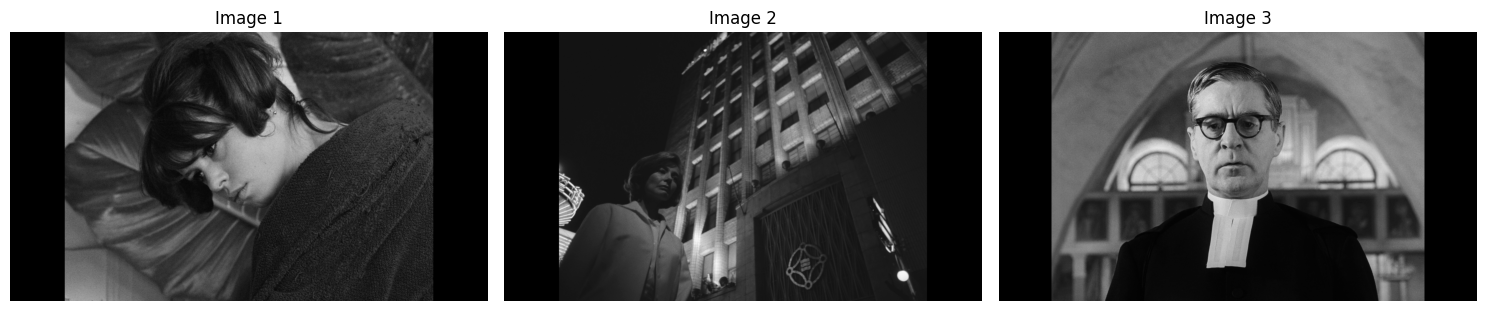

In [47]:
image_paths = ['Daisies.png', 'Hiroshima Mon Amour.png', 'Winter Light.png']

def load_images(path_to_images):
    """
    Loads images from the specified paths and converts them to grayscale.

    Parameters:
    path_to_images: List of image paths to load

    Returns:
    image_arrays: List of numpy arrays representing the grayscale images
    """
    image_arrays = []
    for path in path_to_images:
        img = Image.open(path).convert('L')  # Open image and convert to grayscale
        image_arrays.append(img)
    return image_arrays




loaded_images = load_images(image_paths)

# Create figure and subplots
output_size = (15, 5)
num_images = len(loaded_images)
plot_layout = plt.subplots(1, num_images, figsize=output_size)
figure = plot_layout[0]
display_axes = plot_layout[1]

# Configure each subplot
for idx in range(num_images):
    current_ax = display_axes[idx]
    current_image = loaded_images[idx]

    # Display image and configure appearance
    current_ax.imshow(current_image, cmap='gray')
    current_ax.set_axis_off()
    current_ax.set_title(f"Image {idx+1}")

# Adjust layout and display
figure.tight_layout(pad=1.2)
plt.show()



**Reconstruction of Image**

In order to compress images, we need to use fewer number of singular values in $Σ$. Write a function that reconstructs the input array given the percentage of singular values to keep.

In [50]:
def reconstruct_image(img, SVD_func, sp):
    """
    Reconstructs an image using Singular Value Decomposition (SVD).

    Args:
        img: Input image array
        SVD_func: SVD computation function
        sp: Singular value retention ratio (0-1)

    Returns:
        Array of reconstructed image
    """
    # Decompose image using SVD
    decomposition = list(SVD_func(img))

    # Calculate mask for singular values
    sv_count = min(decomposition[1].shape)
    retention_mask = np.eye(decomposition[1].shape[0], decomposition[1].shape[1])
    retention_mask[int(sv_count * sp):, int(sv_count * sp):] = 0

    # Apply mask to singular values
    decomposition[1] = decomposition[1] * retention_mask

    # Matrix multiplication for reconstruction
    result = np.linalg.multi_dot([
        decomposition[0],
        decomposition[1],
        decomposition[2].T
    ])

    return result

Now reconstruct all the loaded images with ```sp = 0.04 ``` and plot them alongside the original images.

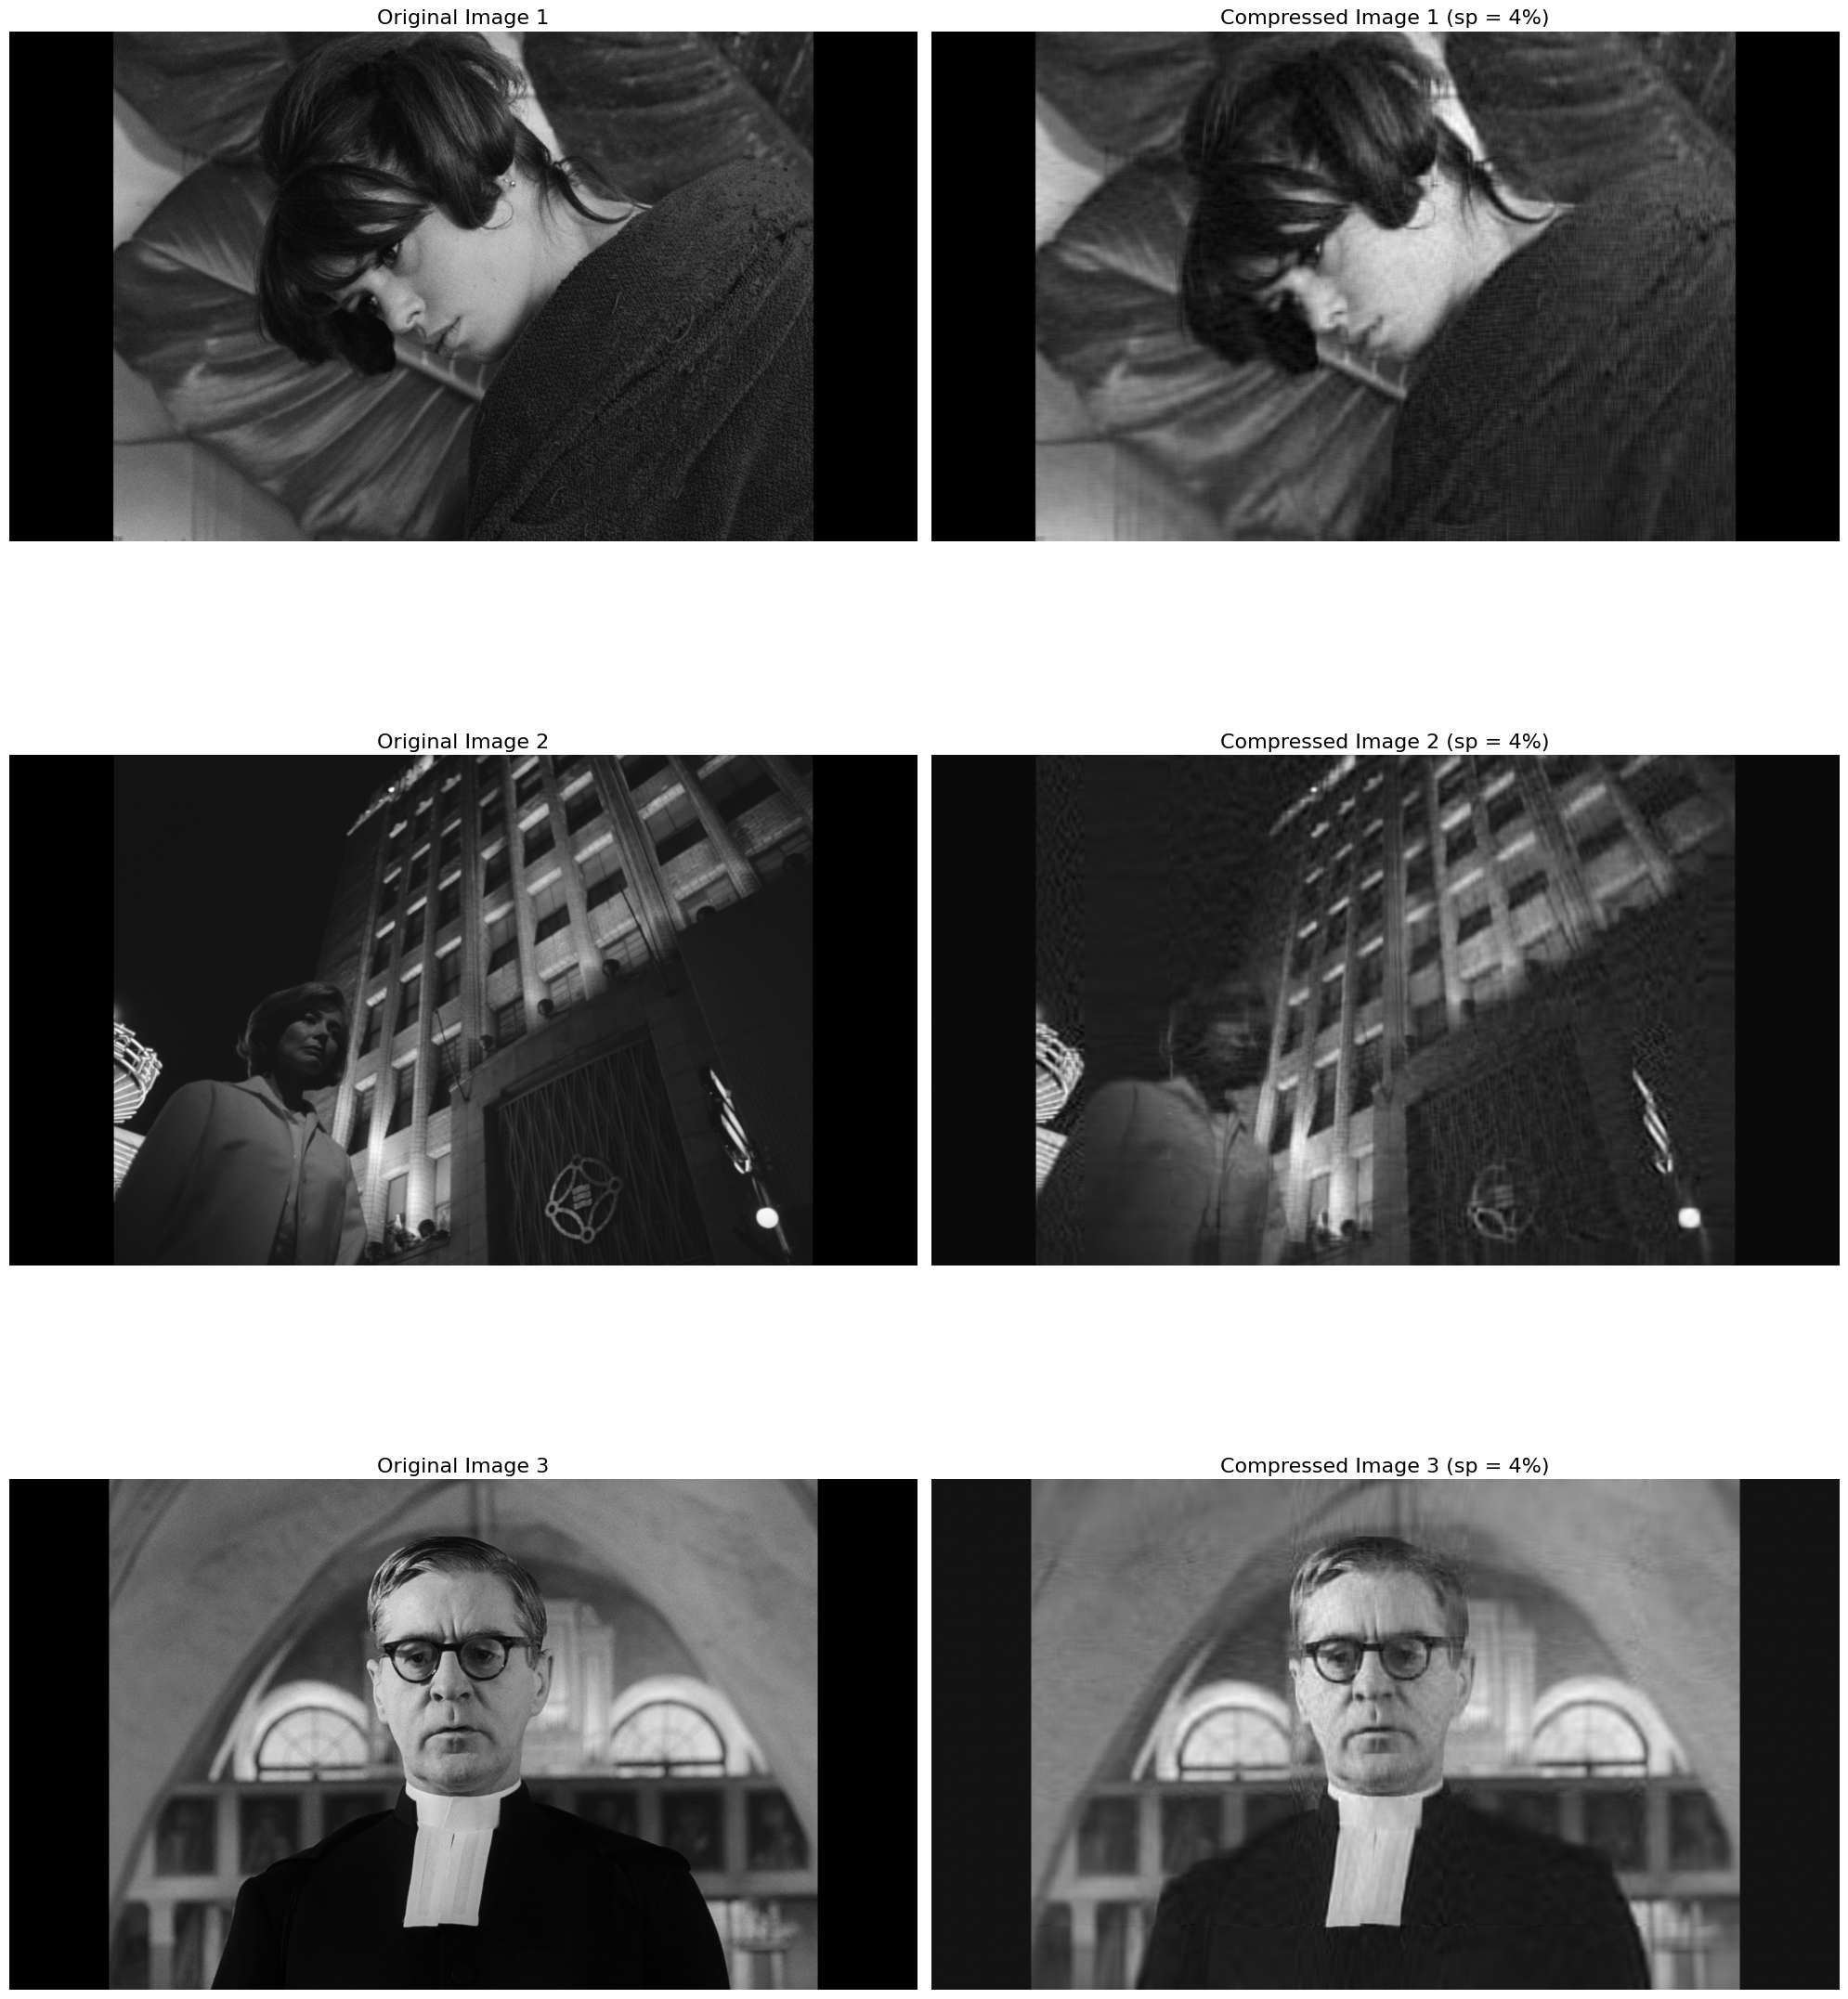

In [51]:
# بازسازی تصاویر با نرخ فشرده‌سازی 4 درصد
compression_ratio = 0.04
reconstructed = list(map(lambda x: reconstruct_image(x, get_svd, compression_ratio), loaded_images))

# تنظیم پارامترهای نمایش
display_config = {
    'figure_size': (20, 25),
    'cmap': 'gray',
    'subplot_layout': (len(loaded_images), 2)
}

# ایجاد فیگور برای نمایش
figure = plt.figure(figsize=display_config['figure_size'])

for idx in range(len(loaded_images)):
    # نمایش تصویر اصلی
    original_plot = plt.subplot(display_config['subplot_layout'][0],
                              display_config['subplot_layout'][1],
                              2*idx + 1)
    original_plot.imshow(loaded_images[idx], cmap=display_config['cmap'])
    original_plot.set_title(f"Original Image {idx + 1}", fontsize=16)
    original_plot.axis('off')

    # نمایش تصویر فشرده شده
    compressed_plot = plt.subplot(display_config['subplot_layout'][0],
                                display_config['subplot_layout'][1],
                                2*idx + 2)
    compressed_plot.imshow(reconstructed[idx], cmap=display_config['cmap'])
    compressed_plot.set_title(f"Compressed Image {idx + 1} (sp = 4%)", fontsize=16)
    compressed_plot.axis('off')

# بهینه‌سازی چیدمان
plt.tight_layout()
plt.show()

You can save the reconstructed images and compare their sizes with the respective original image.

In [52]:
for i in range(len(r_image)):
  plt.imsave(image_paths[i].split('.')[0] + '_compressed.png', r_image[i], cmap='gray')

Choose one of the images and plot the original image and the reconstructed images with ``` sp = [0.2, 0.1, 0.05, 0.03, 0.01] ```.

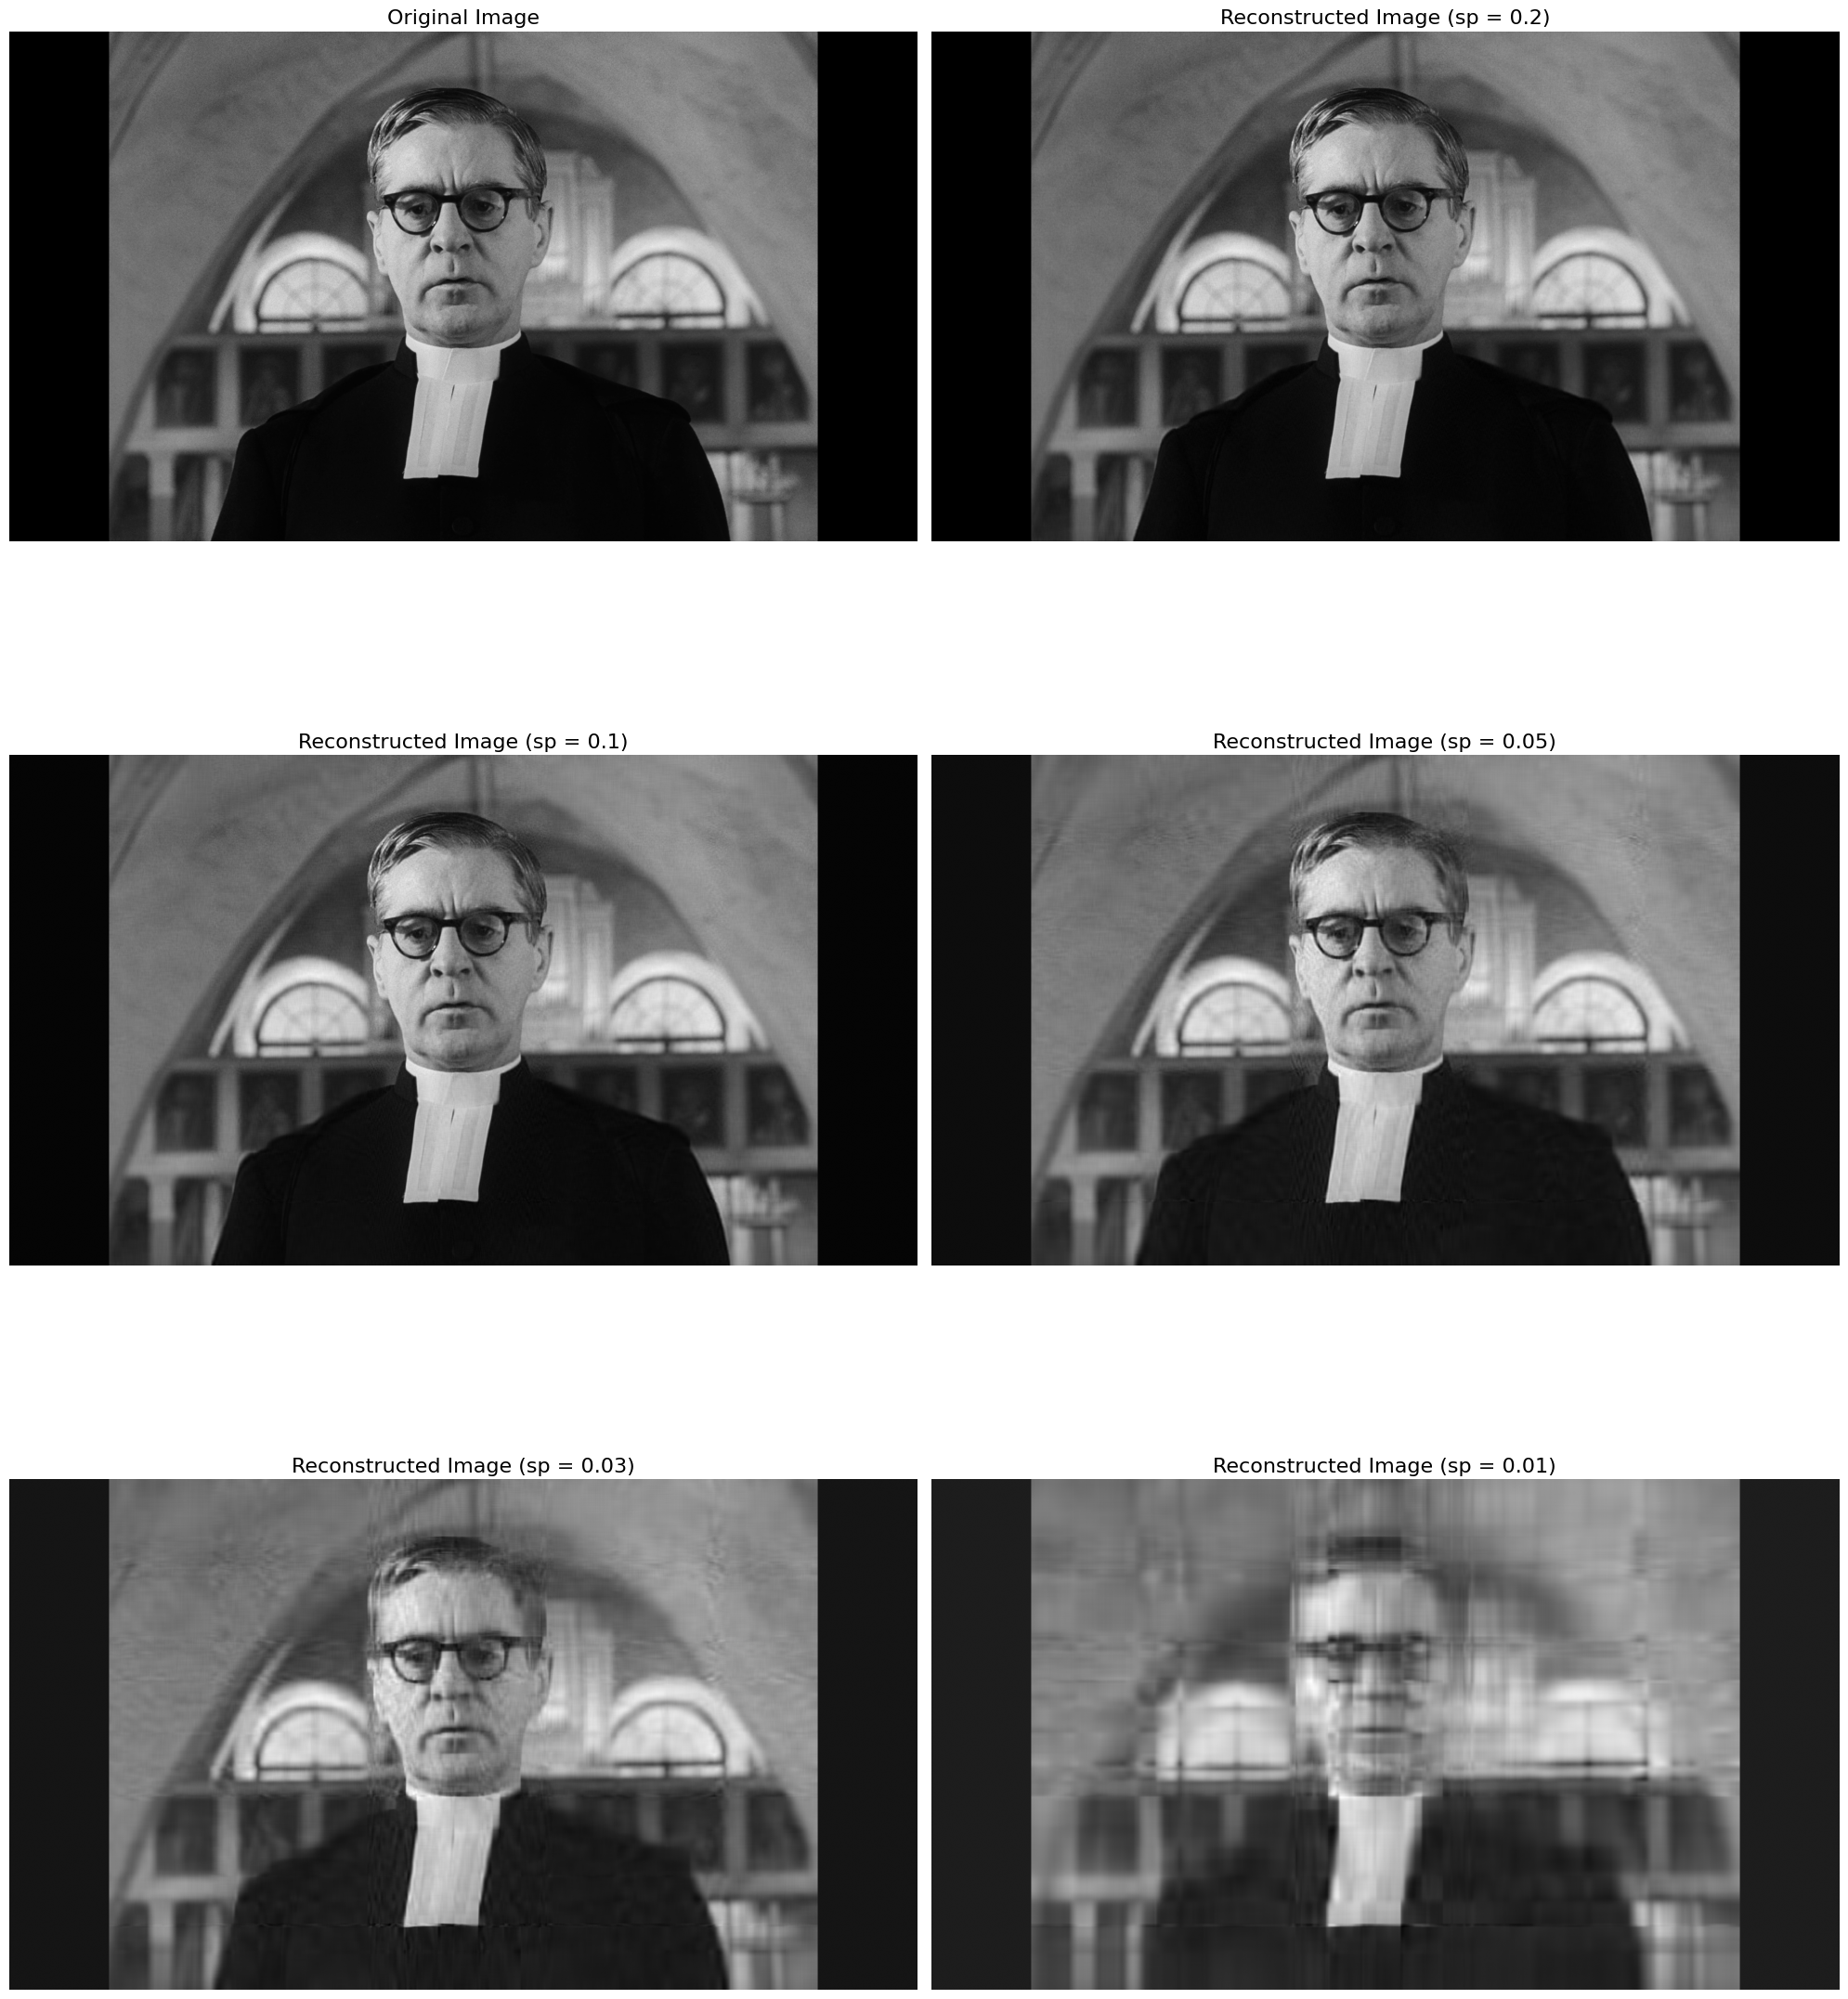

In [53]:
# پارامترهای فشرده‌سازی
compression_levels = [0.2, 0.1, 0.05, 0.03, 0.01]

# تنظیمات نمایش
display_settings = {
   'grid_size': (3, 2),
   'fig_dimensions': (20, 25),
   'colormap': 'gray',
   'title_size': 16
}

# آماده‌سازی تصویر اصلی
source_image = loaded_images[-1]

def generate_compressed_images(image, compression_ratios, svd_function):
   """تولید تصاویر فشرده شده با نرخ‌های مختلف"""
   return [reconstruct_image(image, svd_function, ratio) for ratio in compression_ratios]

# ایجاد فضای نمایش
fig = plt.figure(figsize=display_settings['fig_dimensions'])
total_plots = display_settings['grid_size'][0] * display_settings['grid_size'][1]

# نمایش تصویر اصلی
main_plot = plt.subplot(display_settings['grid_size'][0],
                      display_settings['grid_size'][1], 1)
main_plot.imshow(source_image, cmap=display_settings['colormap'])
main_plot.set_title("Original Image", fontsize=display_settings['title_size'])
main_plot.axis('off')

# تولید و نمایش تصاویر فشرده شده
compressed_images = generate_compressed_images(source_image, compression_levels, get_svd)

for idx, (image, ratio) in enumerate(zip(compressed_images, compression_levels)):
   plot_position = idx + 2  # +2 چون اولین موقعیت برای تصویر اصلی است
   subplot = plt.subplot(display_settings['grid_size'][0],
                        display_settings['grid_size'][1],
                        plot_position)
   subplot.imshow(image, cmap=display_settings['colormap'])
   subplot.set_title(f"Reconstructed Image (sp = {ratio})",
                    fontsize=display_settings['title_size'])
   subplot.axis('off')

# مخفی کردن زیرنمودارهای اضافی
for i in range(len(compression_levels) + 1, total_plots + 1):
   empty_plot = plt.subplot(display_settings['grid_size'][0],
                          display_settings['grid_size'][1], i)
   empty_plot.axis('off')

plt.tight_layout()
plt.show()

# **Latent Semantic Analysis**

In order to demonstrate another application of SVD, we use Latent Semantic Indexing/Analysis as a technique to find out how different words are related to each other.

**Environment Setup**

In [54]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from scipy.sparse.linalg import svds

**Downloading the Dataset**

For this task we will use ```fetch_20newsgroups``` dataset from ```scikit-learn``` package. This dataset contains about 20000 news documents categorized into 20 topics. We will be using 5 of them for convenience.

In [61]:
# تنظیمات دریافت داده
selected_topics = ['rec.motorcycles', 'rec.sport.baseball',
                  'comp.graphics', 'sci.electronics', 'rec.sport.hockey']
seed_value = 42

# دریافت داده‌ها
doc_text = fetch_20newsgroups(
    subset='train',
    categories=selected_topics,
    shuffle=True,
    random_state=seed_value
).data

**Data Transformation**

Since it is not possible to work directly with words, we need to transform the text into numerical data. The tool that will be used is ```TFidfVectorizer``` from scikit-learn that takes both occurrence frequency and importance into account and thus provides better results by focusing on informative words. Create a vectorizer of this type and transform the documents. Use 2000 features to increase efficiency.

In [62]:
# تنظیمات وکتورایزر
vectorizer_config = {
    'max_features': 2000,
    'stop_words': 'english'
}

# ساخت وکتورایزر و تبدیل متن‌ها
text_vectorizer = TfidfVectorizer(**vectorizer_config)
tfidf_matrix = text_vectorizer.fit_transform(doc_text)

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

TF-IDF matrix shape: (2970, 2000)


**Reconstruction**

Now apply SVD on matrix ```C``` and then reconstruct it using ```k = 5``` singular values. You will have to change the data type to ```np.float32``` first.

Notice: As you have probably realized, the manually implemented SVD does not follow an efficient algorithm for the decomposition. Since the matrix ```X``` is much larger than the matrices from the grayscale images, we will be using ```svds``` from ```scipy.sparse.linalg``` that can decompose sparse matrices much faster.

In [63]:
# تنظیم تعداد مؤلفه‌ها
component_count = 5

# تبدیل نوع داده‌ها
feature_matrix = tfidf_matrix.astype(np.float32)

# محاسبه SVD
base_vectors, singular_vals, feature_vectors = svds(feature_matrix, k=component_count)

print(f"Shape of V^T: {feature_vectors.shape}")

# بازسازی ماتریس
sigma_matrix = np.diag(singular_vals)
final_matrix = base_vectors @ sigma_matrix @ feature_vectors

print(f"Reconstructed matrix shape: {final_matrix.shape}")

Shape of V^T: (5, 2000)
Reconstructed matrix shape: (2970, 2000)


Now extract the words from the vectorizer and save it. Then use the previously imported ```cosine_similarity``` to measure how related different words are. You can also see what feature names have been kept in the vectorizer.

In [68]:
# استخراج نام ویژگی‌ها
feature_list = text_vectorizer.get_feature_names_out()

# ذخیره در فایل
def save_features(features, filename="feature_names.txt"):
    with open(filename, "w") as output_file:
        output_file.write('\n'.join(features))
    return len(features)

# نمایش نتیجه
term_count = save_features(feature_list)
print(f"Feature names saved to 'feature_names.txt'. Total terms: {term_count}")

def word_similarity(word1, word2, terms, Vt):
    """محاسبه شباهت کسینوسی بین دو کلمه"""

    # بررسی وجود کلمات
    term_list = terms.tolist()
    if not all(word in term_list for word in [word1, word2]):
        return None

    # پیدا کردن شاخص‌ها
    word_indices = [term_list.index(word) for word in [word1, word2]]

    # استخراج بردارها
    word_vectors = [Vt[:, idx].reshape(1, -1) for idx in word_indices]

    # محاسبه شباهت
    return cosine_similarity(*word_vectors)[0][0]

Feature names saved to 'feature_names.txt'. Total terms: 2000


**Test Performance**

Output the similarity between the two words in each row and check if the measures are sensible.

In [69]:
word_mat = [['grade', 'average'],
            ['grade', 'horse'],
            ['horse', 'ride'],
            ['horse', 'programs'],
            ['programs', 'versions'],
            ['programs', 'toronto'],
            ['hockey', 'ice'],
            ['hockey', 'linux'],
            ['linux', 'windows'],
            ['linux', 'week']]

for first_word, second_word in word_mat:
   sim_score = word_similarity(first_word, second_word, feature_list, feature_vectors)

   result = f"cosine similarity of `{first_word}` and `{second_word}` is: "
   result += str(sim_score) if sim_score is not None else "Word not found"

   print(result)


cosine similarity of `grade` and `average` is: 0.92371017
cosine similarity of `grade` and `horse` is: -0.40158275
cosine similarity of `horse` and `ride` is: 0.9760402
cosine similarity of `horse` and `programs` is: -0.47808278
cosine similarity of `programs` and `versions` is: 0.9599641
cosine similarity of `programs` and `toronto` is: -0.242698
cosine similarity of `hockey` and `ice` is: 0.97020924
cosine similarity of `hockey` and `linux` is: -0.14643398
cosine similarity of `linux` and `windows` is: 0.9665307
cosine similarity of `linux` and `week` is: 0.06830906


### **PCA, Alternative Method**

Principal Component Analysis is another method that can be used for Latent Semantic Analysis. PCA is another dimensionality reduction technique commonly used in machine learning and statistical tasks to transform the data into a simpler space with new variables called principal components where it is easier to analyze data. PCA tries to cause the least loss of information in this process. Before performing PCA, the matrix must be in <b>mean-deviation form</b>. Suppose $[X_{1}, ..., X_{N}]$ is a $p \times N$ matrix of observations (a matrix in which the columns are different samples of data and the rows contain different pieces of information about that sample). The sample mean of $X$ is given by
$$
  M = \frac{1}{N}(X_{1} + ... + X_{N}).
$$
If $\hat{X}_{k}$ is defined as $\hat{X}_{k} = X_{k} - M$ then
$$
B = [\hat{X}_{1}, ..., \hat{X}_{N}]
$$
is in mean-deviation form.

The PCA objective is to find an orthogonal $p \times p$ matrix $P$ that determines the change of variable, $X = PY$ with the property that the new variables in $Y = [y_{1}, ..., y_{n}]^T$ are uncorrelated and are arranged in order of decreasing variance. These variables are then used to reduce the dimensionality of the input.

You can visit this [link](https://www.youtube.com/watch?v=FgakZw6K1QQ) for a better understanding of what PCA is and how it works.

First thing needed to be done is to create a dense array from the transformed matrix ```X```, since PCA works with dense arrays. Then use ```PCA``` on the dense array with 10 principal components. And finally transform the transpose of output.

In [71]:
# تبدیل ماتریس اولیه
feature_array = tfidf_matrix.toarray()

# اعمال PCA
dimension_reducer = PCA(n_components=10)
reduced_features = dimension_reducer.fit_transform(feature_array)

# چرخش ماتریس
final_matrix = reduced_features.T

# نمایش ابعاد
print(f"Shape of the PCA transposed output: {final_matrix.shape}")

Shape of the PCA transposed output: (10, 2970)


As the last step, use the same array of words (```word_mat```) to observe the performance of PCA.

In [73]:
def word_similarity_pca(word1, word2, terms, pca_matrix):
    """محاسبه شباهت کسینوسی دو کلمه با استفاده از ماتریس PCA"""

    # بررسی وجود کلمات
    term_list = terms.tolist()
    if not all(word in term_list for word in [word1, word2]):
        return None

    # استخراج بردارها
    indices = [term_list.index(word) for word in [word1, word2]]
    vectors = [pca_matrix[idx, :].reshape(1, -1) for idx in indices]

    # محاسبه شباهت
    return cosine_similarity(*vectors)[0][0]

# محاسبه شباهت برای جفت کلمات
for first_word, second_word in word_mat:
    sim_score = word_similarity_pca(first_word, second_word, feature_list, final_matrix.T)

    result = f"cosine similarity of `{first_word}` and `{second_word}` is: "
    result += str(sim_score) if sim_score is not None else "Word not found"

    print(result)

cosine similarity of `grade` and `average` is: 0.43824807323835824
cosine similarity of `grade` and `horse` is: 0.4713078668402054
cosine similarity of `horse` and `ride` is: 0.6391679745131218
cosine similarity of `horse` and `programs` is: -0.22003150538499253
cosine similarity of `programs` and `versions` is: -0.3249618274225469
cosine similarity of `programs` and `toronto` is: 0.007674979569698273
cosine similarity of `hockey` and `ice` is: -0.07916682651130408
cosine similarity of `hockey` and `linux` is: -0.17855296379445804
cosine similarity of `linux` and `windows` is: -0.03536021903035564
cosine similarity of `linux` and `week` is: 0.27092839876126135


Compare the result of PCA and SVD for the LSA task based the similarity measure you used. Which one captures the connections between words better? Based on the sparse nature of term-document matrices, explain why this difference in performance appears despite the close relation of PCA and SVD.